In [1]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import shap
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

import warnings
import gc
warnings.filterwarnings("ignore")


Using TensorFlow backend.


In [2]:
data = pd.read_csv('../SHAP/Allmerge2_payment.csv', index_col='acc_id')
data= data.drop(columns='Unnamed: 0')
test = pd.read_csv('../SHAP/Allmerge2_pameny_test.csv', index_col='acc_id')
df = pd.concat([data, test])

In [3]:
df.head()

,amount_spent,amount_spent_pmt,boss_monster,class,combat_char_cnt,combat_play_time,death,enchant_count,etc_cnt,etc_cnt_plg,...,random_attacker_cnt_plg,random_defender_cnt,random_defender_cnt_plg,revive,same_pledge_cnt,same_pledge_cnt_plg,solo_exp,survival_time,temp_cnt,temp_cnt_plg
acc_id,,,,,,,,,,,,,,,,,,,,,
8,0.020310,1.404644,2,485,58.031626,136.879854,91.768298,0.0,0.900892,61.354404,...,33.631748,1.183064,21.745527,92.310423,0.0,29.441536,31.424841,64.0,3.837822,92.455650
20,0.052137,0.896531,8,158,25.515149,66.451919,0.981479,0.0,16.441283,44.409036,...,11.974452,1.183064,6.580883,0.987277,0.0,11.140041,0.274340,64.0,0.479728,28.379435
21,0.184267,2.695461,3,1,0.360893,0.501896,0.000000,0.0,0.225223,0.035391,...,0.000000,0.000000,0.071531,0.000000,0.0,0.000000,20.023885,64.0,2.878367,0.791064
38,0.517168,6.309749,9,216,3.248039,9.101424,0.000000,0.0,2.252231,5.535203,...,0.000000,2.366129,0.286125,0.000000,0.0,0.000000,0.164840,64.0,8.635100,4.845269
41,0.000000,0.035204,0,6,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.0,0.000000,0.000000


In [4]:
df.dtypes

amount_spent               float64
amount_spent_pmt           float64
boss_monster                 int64
class                        int64
combat_char_cnt            float64
combat_play_time           float64
death                      float64
enchant_count              float64
etc_cnt                    float64
etc_cnt_plg                float64
exp_recovery               float64
fishing                    float64
game_money_change          float64
level                        int64
non_combat_play_time       float64
npc_kill                   float64
num_opponent               float64
party_exp                  float64
play_char_cnt              float64
playtime                   float64
pledge_cnt                 float64
pledge_combat_cnt          float64
private_shop               float64
quest_exp                  float64
random_attacker_cnt        float64
random_attacker_cnt_plg    float64
random_defender_cnt        float64
random_defender_cnt_plg    float64
revive              

In [5]:
def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def evaluate(x_data, y_data):
    model = LGBMRegressor(objective='regression', num_iterations=10**5)
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
    val_pred = model.predict(x_val)
    score = rmse_expm1(val_pred, y_val)
    return score

def rfe(x_data, y_data, method, ratio=0.9, min_feats=40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:
        model = LGBMRegressor(objective='regression', num_iterations=10**5)
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=0)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
        val_pred = model.predict(x_val)
        score = rmse_expm1(val_pred, y_val)
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        if method == 'basic':
            feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'perm':
            perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
            feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'shap':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(x_data[feats])
            feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive

feats = [col for col in data.columns if col != 'amount_spent']
len(feats)

34

In [6]:
feats

['class',
 'level',
 'pledge_cnt',
 'random_attacker_cnt',
 'random_defender_cnt',
 'temp_cnt',
 'same_pledge_cnt',
 'etc_cnt',
 'num_opponent',
 'playtime',
 'npc_kill',
 'solo_exp',
 'party_exp',
 'quest_exp',
 'boss_monster',
 'death',
 'revive',
 'exp_recovery',
 'fishing',
 'private_shop',
 'game_money_change',
 'enchant_count',
 'amount_spent_pmt',
 'play_char_cnt',
 'combat_char_cnt',
 'pledge_combat_cnt',
 'random_attacker_cnt_plg',
 'random_defender_cnt_plg',
 'same_pledge_cnt_plg',
 'temp_cnt_plg',
 'etc_cnt_plg',
 'combat_play_time',
 'non_combat_play_time',
 'survival_time']

In [7]:
model = LGBMRegressor(objective='regression', num_iterations=10**5)
x_data = data[feats]
y_data = data['amount_spent']
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
val_pred = model.predict(x_val)
score = rmse_expm1(val_pred, y_val)
score

-53230503152033.4

In [8]:
%%time
basic_archive = rfe(x_data, y_data, 'basic')

34 -53230503152033.4
Wall time: 581 ms


In [9]:
feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp.iloc[:i].index], data['amount_spent']))

40 -53230503152033.4
45 -53230503152033.4
50 -53230503152033.4
55 -53230503152033.4
60 -53230503152033.4
65 -53230503152033.4
70 -53230503152033.4
75 -53230503152033.4
80 -53230503152033.4
85 -53230503152033.4


In [10]:
%%time
perm_archive = rfe(x_data, y_data, 'perm')

34 -53230503152033.4
Wall time: 5.19 s


In [11]:
perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
perm_feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
eli5.show_weights(perm)

Weight,Feature
0.3249 ± 0.0392,x33
0.0952 ± 0.0867,x22
0.0597 ± 0.0299,x11
0.0382 ± 0.0133,x9
0.0187 ± 0.0025,x1
0.0097 ± 0.0039,x0
0.0087 ± 0.0149,x10
0.0042 ± 0.0052,x27
0.0034 ± 0.0031,x28
0.0033 ± 0.0023,x18


In [12]:
for i in range(40, 90, 5):
    print(i, evaluate(data[perm_feat_imp.iloc[:i].index], data['amount_spent']))

40 -53230503152033.4
45 -53230503152033.4
50 -53230503152033.4
55 -53230503152033.4
60 -53230503152033.4
65 -53230503152033.4
70 -53230503152033.4
75 -53230503152033.4
80 -53230503152033.4
85 -53230503152033.4


In [13]:
%%time
shap_archive = rfe(x_data, y_data, 'shap')

34 -53230503152033.4
Wall time: 1.57 s


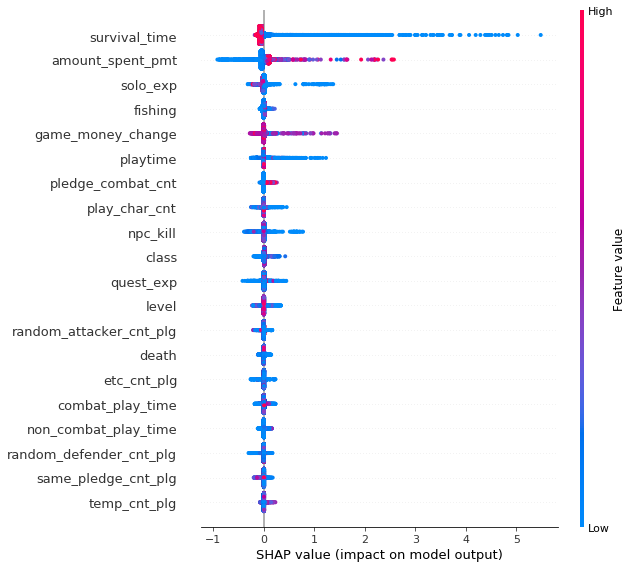

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)
shap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
shap.summary_plot(shap_values, x_data)

In [15]:
for i in range(40, 90, 5):
    print(i, evaluate(data[shap_feat_imp.iloc[:i].index], data['amount_spent']))

40 -53230503152033.4
45 -53230503152033.4
50 -53230503152033.4
55 -53230503152033.4
60 -53230503152033.4
65 -53230503152033.4
70 -53230503152033.4
75 -53230503152033.4
80 -53230503152033.4
85 -53230503152033.4


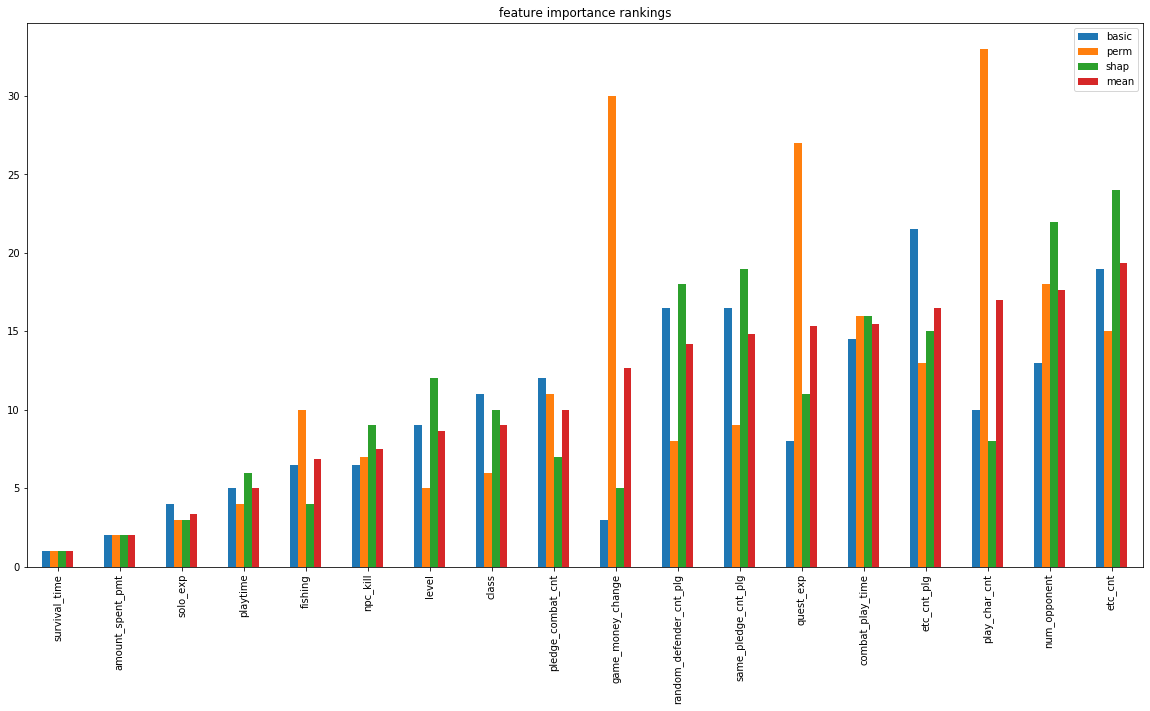

In [16]:
feat_imp_archive = pd.DataFrame(index=feats, columns=['basic', 'perm', 'shap', 'mean'])
feat_imp_archive['basic'] = feat_imp.rank(ascending=False)
feat_imp_archive['perm'] = perm_feat_imp.rank(ascending=False)
feat_imp_archive['shap'] = shap_feat_imp.rank(ascending=False)
feat_imp_archive['mean'] = feat_imp_archive[['basic', 'perm', 'shap']].mean(axis=1)
feat_imp_archive = feat_imp_archive.sort_values('mean')
feat_imp_archive[feat_imp_archive['mean']<20].plot(kind='bar', figsize=(20, 10), title='feature importance rankings');

In [17]:
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp_archive.iloc[:i].index], data['amount_spent']))

40 -53230503152033.4
45 -53230503152033.4
50 -53230503152033.4
55 -53230503152033.4
60 -53230503152033.4
65 -53230503152033.4
70 -53230503152033.4
75 -53230503152033.4
80 -53230503152033.4
85 -53230503152033.4


In [18]:
%%time
rf = RandomForestRegressor(n_jobs=-1, n_estimators=200, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=0)
feat_selector.fit(data[feats].values, data['amount_spent'].values)

Wall time: 1min 21s


BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                         max_depth=5, max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=63, n_jobs=-1,
                                         oob_score=False,
                                         random_state=<mtrand.RandomState object at 0x000002315163D5A0>,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto', perc=100,
         random_state=<mtrand.RandomState object at 0x000002315163D5A0>,
         t

In [19]:
evaluate(data[np.array(feats)[feat_selector.support_]], data['amount_spent'])

-53230503152032.0

In [20]:

import numpy as np

import pandas as pd



import keras

import tensorflow as tf

from IPython.display import display

import PIL

 

In [21]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11105396212337651407
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4945621811
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6084542759300891263
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [22]:
from keras import backend as K

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [23]:
# # gpu_test.py

# import sys
# import numpy as np
# import tensorflow as tf
# from datetime import datetime

# shape = (int(10000), int(10000))

# # with tf.device("/cpu:0"):
# with tf.device("/gpu:0"):
#     random_matrix = tf.random_uniform(shape=shape, minval=0, maxval=1)
#     dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
#     sum_operation = tf.reduce_sum(dot_operation)

# startTime = datetime.now()
# with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
#     result = session.run(sum_operation)
#     print(result)

# print("\n" * 2)
# print("Time taken:", datetime.now() - startTime)
# print("\n" * 2)